# Prediction models by codes
In this notebook we consider ICD9 diagnosis and precedure codes as predictors to predict the 30-day readmission rate.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import os

In [2]:
%matplotlib inline

In [ ]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [3]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [4]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [6]:
with open('output/hyper_tune_large.csv', 'w') as f:
    f.write('depth,width,DX_dim,hosp_dim,lr,dropout,batchsize,auc\n')

In [4]:
hyper_df = pd.read_csv('./hyper_tune.csv')

In [5]:
hyper_df[hyper_df['auc']>0.59]

,depth,width,DX_dim,hosp_dim,auc
7,20,128,5,5,0.592
22,10,128,50,3,0.592
30,3,128,5,1,0.604
33,1,64,5,5,0.591
35,3,64,10,5,0.598


## Data reading and splitting

In [6]:
core_dtypes_pd = {'AGE': float,
 'AWEEKEND': float,
 'DIED': float,
 'DISCWT': float,
 'DISPUNIFORM': float,
 'DMONTH': float,
 'DQTR': float,
 'DRG': float,
 'DRGVER': float,
 'DRG_NoPOA': float,
 'DX1': bytes,
 'DX10': bytes,
 'DX11': bytes,
 'DX12': bytes,
 'DX13': bytes,
 'DX14': bytes,
 'DX15': bytes,
 'DX16': bytes,
 'DX17': bytes,
 'DX18': bytes,
 'DX19': bytes,
 'DX2': bytes,
 'DX20': bytes,
 'DX21': bytes,
 'DX22': bytes,
 'DX23': bytes,
 'DX24': bytes,
 'DX25': bytes,
 'DX26': bytes,
 'DX27': bytes,
 'DX28': bytes,
 'DX29': bytes,
 'DX3': bytes,
 'DX30': bytes,
 'DX4': bytes,
 'DX5': bytes,
 'DX6': bytes,
 'DX7': bytes,
 'DX8': bytes,
 'DX9': bytes,
 'DXCCS1': float,
 'DXCCS10': float,
 'DXCCS11': float,
 'DXCCS12': float,
 'DXCCS13': float,
 'DXCCS14': float,
 'DXCCS15': float,
 'DXCCS16': float,
 'DXCCS17': float,
 'DXCCS18': float,
 'DXCCS19': float,
 'DXCCS2': float,
 'DXCCS20': float,
 'DXCCS21': float,
 'DXCCS22': float,
 'DXCCS23': float,
 'DXCCS24': float,
 'DXCCS25': float,
 'DXCCS26': float,
 'DXCCS27': float,
 'DXCCS28': float,
 'DXCCS29': float,
 'DXCCS3': float,
 'DXCCS30': float,
 'DXCCS4': float,
 'DXCCS5': float,
 'DXCCS6': float,
 'DXCCS7': float,
 'DXCCS8': float,
 'DXCCS9': float,
 'ECODE1': bytes,
 'ECODE2': bytes,
 'ECODE3': bytes,
 'ECODE4': bytes,
 'ELECTIVE': float,
 'E_CCS1': float,
 'E_CCS2': float,
 'E_CCS3': float,
 'E_CCS4': float,
 'FEMALE': float,
 'HCUP_ED': float,
 'HOSP_NRD': float,
 'KEY_NRD': float,
 'LOS': float,
 'MDC': float,
 'MDC_NoPOA': float,
 'NCHRONIC': float,
 'NDX': float,
 'NECODE': float,
 'NPR': float,
 'NRD_DaysToEvent': float,
 'NRD_STRATUM': float,
 'NRD_VisitLink': bytes,
 'ORPROC': float,
 'PAY1': float,
 'PL_NCHS': float,
 'PR1': bytes,
 'PR10': bytes,
 'PR11': bytes,
 'PR12': bytes,
 'PR13': bytes,
 'PR14': bytes,
 'PR15': bytes,
 'PR2': bytes,
 'PR3': bytes,
 'PR4': bytes,
 'PR5': bytes,
 'PR6': bytes,
 'PR7': bytes,
 'PR8': bytes,
 'PR9': bytes,
 'PRCCS1': float,
 'PRCCS10': float,
 'PRCCS11': float,
 'PRCCS12': float,
 'PRCCS13': float,
 'PRCCS14': float,
 'PRCCS15': float,
 'PRCCS2': float,
 'PRCCS3': float,
 'PRCCS4': float,
 'PRCCS5': float,
 'PRCCS6': float,
 'PRCCS7': float,
 'PRCCS8': float,
 'PRCCS9': float,
 'PRDAY1': float,
 'PRDAY10': float,
 'PRDAY11': float,
 'PRDAY12': float,
 'PRDAY13': float,
 'PRDAY14': float,
 'PRDAY15': float,
 'PRDAY2': float,
 'PRDAY3': float,
 'PRDAY4': float,
 'PRDAY5': float,
 'PRDAY6': float,
 'PRDAY7': float,
 'PRDAY8': float,
 'PRDAY9': float,
 'REHABTRANSFER': float,
 'RESIDENT': float,
 'SAMEDAYEVENT': bytes,
 'SERVICELINE': float,
 'TOTCHG': float,
 'YEAR': float,
 'ZIPINC_QRTL': float}

Read the same admissions as in the comorbidities dataset, but the variables from the core data set:

In [7]:
ami_index = pd.read_csv(path+'cohorts/ami_index.csv', dtype=core_dtypes_pd)

train_comorb = pd.read_csv(path+'cohorts/ami/comorb_train.csv')
test_comorb = pd.read_csv(path+'cohorts/ami/comorb_test.csv')

train_df = ami_index[ami_index['KEY_NRD'].isin(train_comorb['KEY_NRD'])]
tst_df = ami_index[ami_index['KEY_NRD'].isin(test_comorb['KEY_NRD'])]

N_trn = len(train_df)
N_tst = len(tst_df)
all_df = pd.concat([train_df, tst_df])

del(ami_index, train_comorb, test_comorb)

## Prediction by raw ICD9 diagnosis codes

In [8]:
from keras.layers import Input, Embedding, concatenate, Reshape, BatchNormalization, add
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam

/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc

### Data Preparation

DX2-DX30 are considered as categorical variables that share levels (around 6000 levels). We change their values into integers from 0 to number of levels, so that they can feed into embedding layers. 

In [11]:
N_DX = 29
DXs = ['DX'+str(n) for n in range(2, N_DX+2)]

## Additive Emedding

In [129]:
DX_series = pd.concat([all_df[DX] for DX in DXs])
DX_series = DX_series.fillna('missing')
DX_series = DX_series.astype('category')

DX_cat = DX_series.cat.categories
n_DX_cat = len(DX_cat)
DX_series = DX_series.cat.rename_categories(range(n_DX_cat))

DX_mat = DX_series.astype(int).values.reshape(len(all_df), N_DX)

The demographic variables are age and gender. Age is normalized to the same scale as other variables. 

In [11]:
demo_mat = all_df[['AGE', 'FEMALE']].values

age_mean = all_df['AGE'].mean()
age_std = all_df['AGE'].std()

demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std

Hospital is a categorical variable with around 800 levels. It will be processed as embedding, just like DXns.

In [12]:
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories
hosp_series = hosp_series.cat.rename_categories(range(len(hosp_cat)))
hosp_array = hosp_series.astype(int).values

DX1 is a categorical variable with 20 levels. It will be transformed into one-hot-encoding matrix before feed into neural nets. 

In [13]:
DX1_series = all_df['DX1'].astype('category')
DX1_cat = DX1_series.cat.categories
DX1_series = DX1_series.cat.rename_categories(range(len(DX1_cat)))
DX1_array = DX1_series.astype(int).values

DX1_mat = to_categorical(DX1_array, num_classes=len(DX1_cat))

The label/outcome in this problem is the whether there is an unexpected all-cause 30-day readmission following this index admission. It is considered as an integer with value 0 and 1. 

In [14]:
y = all_df['readm30'].values.astype(int)

y_train = to_categorical(y[:N_train])
y_test = to_categorical(y[N_train:])

In [45]:
DX_mat.shape, demo_mat.shape, hosp_array.shape, DX1_mat.shape, y.shape

((195695, 29), (195695, 2), (195695,), (195695, 20), (195695,))

### Model Building

In [15]:
def sc_block(input_tensor, nodes):
    '''Short-cut block'''
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(nodes)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(nodes)(x)
    x = BatchNormalization()(x)
    
    x = add([input_tensor, x])
    x = Activation('relu')(x)
    return x

In [131]:
#width = 128
#depth = 2
DX_embed_dim = 1
hosp_embed_dim = 3

input_DX = Input(shape = (N_DX,))
DX_embed = Embedding(input_dim=n_DX_cat, output_dim=DX_embed_dim, input_length=N_DX)(input_DX)
DX_embed = Reshape((N_DX*DX_embed_dim,))(DX_embed)

input_demo = Input(shape=(2, ))

input_DX1 = Input(shape=(len(DX1_cat),))

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, DX_embed, hosp_embed], axis=1)

In [132]:
merged.shape

TensorShape([Dimension(None), Dimension(26)])

In [133]:
x = Dense(64)(merged)
x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = Dense(256)(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
#x = Dense(512)(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
x = Dense(32)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
#x = Dense(16, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 29)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 29, 10)       54580       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 3)         2607        input_4[0][0]                    
__________________________________________________________________________________________________
input_2 (I

In [134]:
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [135]:
checkpointer = ModelCheckpoint(filepath=model_path+'ami_icd9_1.h5', verbose=0, save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [60]:
class_weight = {0:(y_train.shape[0]/sum(y_train[:, 0])), 1:(y_train.shape[0]/sum(y_train[:, 1]))}

In [136]:
hist = model.fit([demo_mat[:N_train, :], DX1_mat[:N_train, :], DX_mat[:N_train, :], hosp_array[:N_train]], y_train, 
                 batch_size=512, epochs=100, callbacks=[checkpointer, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[demo_mat[N_train:, :], DX1_mat[N_train:, :], DX_mat[N_train:, :], hosp_array[N_train:]], y_test], 
                verbose=2)

Train on 136392 samples, validate on 45465 samples
Epoch 1/100
 - 4s - loss: 1.6792 - acc: 0.5744 - val_loss: 0.6311 - val_acc: 0.6058
Epoch 2/100
 - 2s - loss: 1.4562 - acc: 0.5358 - val_loss: 0.6519 - val_acc: 0.5751
Epoch 3/100
 - 2s - loss: 1.3870 - acc: 0.5344 - val_loss: 0.6583 - val_acc: 0.5583
Epoch 4/100
 - 2s - loss: 1.3526 - acc: 0.5347 - val_loss: 0.6577 - val_acc: 0.5629
Epoch 5/100
 - 2s - loss: 1.3353 - acc: 0.5401 - val_loss: 0.6506 - val_acc: 0.5609
Epoch 6/100
 - 2s - loss: 1.3231 - acc: 0.5514 - val_loss: 0.6630 - val_acc: 0.5535
Epoch 7/100
 - 2s - loss: 1.3099 - acc: 0.5560 - val_loss: 0.6434 - val_acc: 0.5820
Epoch 8/100
 - 2s - loss: 1.2996 - acc: 0.5644 - val_loss: 0.6384 - val_acc: 0.5953
Epoch 9/100
 - 2s - loss: 1.2888 - acc: 0.5709 - val_loss: 0.6537 - val_acc: 0.5723
Epoch 10/100
 - 2s - loss: 1.2843 - acc: 0.5757 - val_loss: 0.6541 - val_acc: 0.5609
Epoch 11/100
 - 2s - loss: 1.2751 - acc: 0.5749 - val_loss: 0.6462 - val_acc: 0.5738
Epoch 12/100
 - 2s - lo

In [137]:
model.load_weights(model_path+'ami_icd9_1.h5')
y_pred = model.predict([demo_mat[N_train:, :], DX1_mat[N_train:, :], DX_mat[N_train:, :], hosp_array[N_train:]], batch_size=256)

{0: 0.5899000984297051}

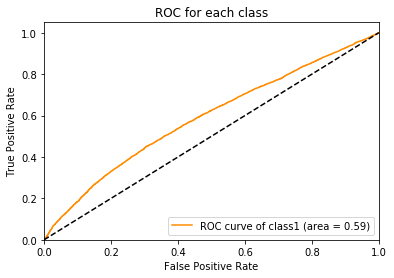

In [138]:
plot_roc(y_pred[:, 0], y_test[:, 0])

#### Save data for hyper parameter tuning:

In [63]:
np.savez(path+'temp/data_temp.npz', demo_mat=demo_mat, DX1_mat=DX1_mat, DX_mat=DX_mat, hosp_array=hosp_array, y_train=y_train, 
        y_test=y_test, n_DX_cat=n_DX_cat, n_DX1_cat = len(DX1_cat), n_hosp_cat=len(hosp_cat))

### Prediction model by summing over DX embedding